In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
from contextlib import contextmanager
from functools import wraps, partial

import os

from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances
import imageio
from yellowbrick.text import TSNEVisualizer
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling
from sklearn import metrics


/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609]
Version info.
sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


In [3]:
import pickle
def save(mapping_dict, name):
    with open('data/{}.pickle'.format(name), 'wb') as handle:
        pickle.dump(mapping_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load(name):
    with open('data/{}.pickle'.format(name), 'rb') as handle:
        return pickle.load(handle)
    

def save_result(file_name=None, calculate=False, skip=False):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            
            final_file_name = kwargs['file_name'] if 'file_name' in kwargs else file_name
            
            if calculate:
                result = func(*args, **kwargs)
                if final_file_name:
                    if isinstance(result, pd.DataFrame):
                        result.to_parquet('data/{}.parquet'.format(final_file_name))
                    elif isinstance(result, matplotlib.figure.Figure):
                        result.savefig('img/{}.png'.format(result._suptitle._text), dpi=100)
                        save(result, result._suptitle._text)
                        return
                    else:
                        save(result, final_file_name)
                return result
            else:
                if not skip and 'title' in kwargs:
                    display('read {}'.format(kwargs['title']))
                    return load(kwargs['title'])                    
                if not skip and final_file_name:
                    display('read {}'.format(final_file_name))
                    if os.path.isfile('data/{}.parquet'.format(final_file_name)) :
                        return pd.read_parquet('data/{}.parquet'.format(final_file_name))
                    else:
                        return load(final_file_name)                    
                else:
                    display('code skipped')
                    return
        return wrapper

    return decorator

# Prepare DataSet

In [4]:
from sklearn.datasets import fetch_20newsgroups

In [5]:
def generate_new_clusters(obj, mapping):
    for v in mapping.values():
        for i in obj:
            if v.startswith(i):
                yield i

@save_result('mydata')
def load_dataset():
    mydata = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
    display('Training data size:', len(mydata['data']))
    return mydata 

@save_result('mappings')
def generate_mappings(mydata):
    a = [np.unique(['.'.join(i.split('.')[:k]) for i in mydata.target_names]) for k in range(1,4)]
    targets = np.unique(mydata.target)
    mapping1 = dict(zip(targets, a[2]))
    mapping2 = dict(zip(targets, generate_new_clusters(a[1], mapping1)))
    mapping3 = dict(zip(targets, generate_new_clusters(a[0], mapping1)))
    return mapping1, mapping2, mapping3

In [6]:
dset = load_dataset()

'read mydata'

In [7]:
res = generate_mappings(dset)
if res:
    for mapping in res:
        print(mapping, '\n')

'read mappings'

{0: 'alt.atheism', 1: 'comp.graphics', 2: 'comp.os.ms-windows', 3: 'comp.sys.ibm', 4: 'comp.sys.mac', 5: 'comp.windows.x', 6: 'misc.forsale', 7: 'rec.autos', 8: 'rec.motorcycles', 9: 'rec.sport.baseball', 10: 'rec.sport.hockey', 11: 'sci.crypt', 12: 'sci.electronics', 13: 'sci.med', 14: 'sci.space', 15: 'soc.religion.christian', 16: 'talk.politics.guns', 17: 'talk.politics.mideast', 18: 'talk.politics.misc', 19: 'talk.religion.misc'} 

{0: 'alt.atheism', 1: 'comp.graphics', 2: 'comp.os', 3: 'comp.sys', 4: 'comp.sys', 5: 'comp.windows', 6: 'misc.forsale', 7: 'rec.autos', 8: 'rec.motorcycles', 9: 'rec.sport', 10: 'rec.sport', 11: 'sci.crypt', 12: 'sci.electronics', 13: 'sci.med', 14: 'sci.space', 15: 'soc.religion', 16: 'talk.politics', 17: 'talk.politics', 18: 'talk.politics', 19: 'talk.religion'} 

{0: 'alt', 1: 'comp', 2: 'comp', 3: 'comp', 4: 'comp', 5: 'comp', 6: 'misc', 7: 'rec', 8: 'rec', 9: 'rec', 10: 'rec', 11: 'sci', 12: 'sci', 13: 'sci', 14: 'sci', 15: 'soc', 16: 'talk', 17: '

In [8]:
TARGET_COLUMNS = ['clusters', 'clusters_2', 'clusters_3']
TEXT_COLUMN = 'data'

In [9]:
@save_result('df', calculate=False)
def prepare_raw_df(mydata, mapping1, mapping2, mapping3):
    df = pd.DataFrame({'data': mydata.data, 'target': mydata.target})
    for mapping, col in zip([mapping1, mapping2, mapping3], TARGET_COLUMNS):
        le = LabelEncoder()
        df[col] = le.fit_transform(df['target'].apply(lambda x: mapping[x]))    
        save(dict(enumerate(le.classes_)), col)
    return df.drop(columns=['target']).drop_duplicates().reset_index(drop=True)

In [10]:
prepare_raw_df(dset, *generate_mappings(dset)).head()

'read mappings'

'read df'

,data,clusters,clusters_2,clusters_3
0,\n\nI am sure some bashers of Pens fans are pr...,10,8,3
1,My brother is in the market for a high-perform...,3,3,1
2,\n\n\n\n\tFinally you said what you dream abou...,17,14,6
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,3,1
4,1) I have an old Jasmine drive which I cann...,4,3,1


In [11]:
import gc
class DataAdapter:
    def __init__(self, df, **kwargs):
        self.data = df.copy()

    @property
    def _text_data(self):
        return  self.data[TEXT_COLUMN]
    
    def get_target(self, num):
        return self.data[TARGET_COLUMNS[num]]
        
    def update_data(self, df):
        del self.data
        gc.collect()
        self.data = df.copy()
        
    @save_result('-', calculate=False, skip=False)    
    def calculate_kmenas(self, num_clusters, file_name=None):
        return KMeans(n_clusters=num_clusters).fit_predict(self.vectors)
    
    def calculate_metrics(self, num):
        # Compute confusion matrix
        truth = self.get_target(num).values

        num_clus = len(set(truth))
        k_labels = self.calculate_kmenas(num_clus, file_name='kmenas_{}'.format(num_clus))

        return {
            'adjusted_rand_score': metrics.adjusted_rand_score(truth, k_labels),
            'adjusted_mutual_info_score': metrics.adjusted_mutual_info_score(truth, k_labels),

            'homogeneity_score': metrics.homogeneity_score(truth, k_labels),
            'completeness_score': metrics.completeness_score(truth, k_labels),
            'v_measure_score': metrics.v_measure_score(truth, k_labels),

        }

In [12]:
from wordcloud import WordCloud

class Plotter:
    
    @save_result('-', calculate=False, skip=True)
    def plot_clusters(self, func, title='title'):
        fig, axs = plt.subplots(1, 3, figsize=(19, 3), sharey=False)
        for num, col in enumerate(TARGET_COLUMNS):
            self.plot(axs[num], self.convert_params(*func(self.data, col)))
        fig.suptitle(title)
        return fig

    @save_result('-', calculate=False, skip=True)    
    def clusters_wordcloud(self, name, title='title'):
        mapping = load(name)
        pdf = pd.DataFrame(self.data.groupby(name).agg(TEXT_COLUMN).sum())

        fig = plt.figure(figsize=(20, 25))
        for i in range(len(mapping)):
            ax = fig.add_subplot(7,3,i+1)
            wordcloud = WordCloud().generate(pdf['data'][i])
            ax.set_title("WordCloud " + mapping[pdf.index[i]])
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis('off')
        fig.suptitle(title)
        return fig
    
    @save_result('-', calculate=True, skip=False)    
    def clusters_tsne(self, num, title='title'):
        tsne = TSNEVisualizer()
        tsne.fit(self.vectors, self.get_target(num))
        f = tsne.show().figure
        f.set_figheight(15)
        f.set_figwidth(15)
        f.suptitle(title)
        return f

    @save_result('-', calculate=True, skip=False)    
    def plot_confusion_matrix(self, num, title='title'):

        # Compute confusion matrix
        truth = self.get_target(num).values
         
        num_clus = len(set(truth))
        k_labels = self.calculate_kmenas(num_clus, file_name='kmenas_{}'.format(num_clus))

        
        fig = plt.figure(figsize=(8, 8))
        mat = confusion_matrix(truth, k_labels)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=set(truth),
                    yticklabels=set(truth))
        plt.xlabel('true label')
        plt.ylabel('predicted label');
        fig.suptitle(title)
        return fig

    
    @staticmethod
    @save_result('-', calculate=False, skip=True)
    def plot_linkage_matrix(linkage_matrix, ylimit=None, title="ward_clusters", truncate_mode=None, p=5):
        fig, ax = plt.subplots(figsize=(15, 20))

        kwargs = {
            'leaf_rotation':90.,  # rotates the x axis labels
            'leaf_font_size':8.,  # font size for the x axis labels
            'show_contracted':False,  # to get a distribution impression in truncated branches
            'show_leaf_counts':False,  # otherwise numbers in brackets are counts

        }
        if truncate_mode:
            kwargs.update({
                'truncate_mode':truncate_mode,  # show only the last p merged clusters
                'p':p,  # show only the last p merged clusters
            })

        axs = dendrogram(linkage_matrix, **kwargs);

        if ylimit:
            ax.set_ylim(*ylimit)

        plt.tick_params(
            axis= 'x',         # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')

        plt.tight_layout(); #show plot with tight layout
        fig.suptitle(title)
        return fig


class PlotterBar(Plotter):

    @staticmethod
    def convert_params(x,y):
        return { "x": x, "height": y}

    def plot(self, ax, params):
        ax.bar(**params)

class PlotterScatter(Plotter):

    @staticmethod
    def convert_params(x,y,z):
        return {'x': x, 'y': y, 'c': z}
    
    def plot(self, ax, params):
        ax.scatter(**params)

    def plot_clusters_svd(self, func):
        svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
        svd_df = pd.DataFrame(data=svd.fit_transform(self.vectors), index=self.data.index, columns=["x", "y"])
        self.plot_clusters(partial(func, svd_df=svd_df), title='scatter plot for clusters SVD')
        
    def plot_clusters_svd_deep(self, func, with_text_features=True, n_components=300):
        title = 'scatter plot for clusters SVD & then PCA {} {}'.format(with_text_features, n_components)
        svd = TruncatedSVD(n_components=15, n_iter=7, random_state=42)
        features = svd.fit_transform(self.vectors)

        if with_text_features:
            tmp = self.data[['word_count', 'length', 'word_density', 'compound', 'neg', 'neu', 'pos']]
            tmp = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(tmp)
            tmp = StandardScaler().fit_transform(tmp)
            features = np.concatenate([np.array(tmp),features], axis=1)

        pca = PCA(n_components=2, random_state=42)
        svd_df = pd.DataFrame(data=pca.fit_transform(features), index=self.data.index, columns=["x", "y"])
        self.plot_clusters(partial(func, svd_df=svd_df), title=title)

# Preproccessing DataSet

In [13]:
class PreproccessingAdapter(DataAdapter, PlotterBar):
    pass

In [14]:
adapter = PreproccessingAdapter(prepare_raw_df(dset, *generate_mappings(dset)))

'read mappings'

'read df'

# Clusters Frequency

In [15]:
def get_frequency(df, column_name):
    targets, frequency = np.unique(df[column_name], return_counts=True)
    return range(len(targets)), frequency

adapter.plot_clusters(get_frequency, title='Clusters Frequency');

'code skipped'

In [16]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import tokenize

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader_analyzer = SentimentIntensityAnalyzer()

def word_lemmatizer(word):
    word = word.replace('_', '')
    word1 = wordnet_lemmatizer.lemmatize(word, pos = "n") # NOUNS
    word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v") # VERB
    return wordnet_lemmatizer.lemmatize(word2, pos = ("a")) # ADJ
    

def text_lemmatizer(text):
    return ' '.join(map(word_lemmatizer, text))


def lemmatizer(x):
    x[TEXT_COLUMN] = x[TEXT_COLUMN].apply(lambda text: text_lemmatizer(tokenize(remove_stopwords(text))))
    return x

def get_sentimnent(x):
    x['sentimnent'] = x[TEXT_COLUMN].apply(lambda text: vader_analyzer.polarity_scores(text))
    return x

def text_feature_selector(x):
    x['word_count'] = x[TEXT_COLUMN].apply(lambda text : len(str(text).split()))
    x['length'] = x[TEXT_COLUMN].apply(len)
    x['word_density'] = x['length'] / x['word_count']
    return x

[nltk_data] Downloading package wordnet to /home/dlab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /home/dlab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
@save_result('preprocessed_df', calculate=False)
def nlp_preprocessing(df):
    display(df.shape)
    df = FunctionTransformer(lemmatizer, validate=False).transform(df)
    display(df.shape)
    df = FunctionTransformer(text_feature_selector, validate=False).transform(df)
    display(df.shape)
    df = FunctionTransformer(get_sentimnent, validate=False).transform(df)
    display(df.shape)
    df = pd.concat([df, pd.io.json.json_normalize(df['sentimnent'])], axis=1).drop(columns=['sentimnent'])
    display(df.shape)
    return df

In [18]:
adapter.update_data(nlp_preprocessing(adapter.data))

'read preprocessed_df'

In [19]:
adapter.data.head()

,data,clusters,clusters_2,clusters_3,word_count,length,word_density,compound,neg,neu,pos
0,I sure bashers Pens fan pretty confuse lack ki...,10,8,3,71,400,5.633803,0.5719,0.244,0.466,0.290
1,My brother market high performance video card ...,3,3,1,39,232,5.948718,0.8225,0.029,0.752,0.219
2,Finally say dream about Mediterranean That new...,17,14,6,161,926,5.751553,-0.9970,0.366,0.555,0.079
3,Think It s SCSI card DMA transfer NOT disk The...,3,3,1,82,476,5.804878,0.9153,0.000,0.822,0.178
4,I old Jasmine drive I use new system My unders...,4,3,1,58,342,5.896552,0.5574,0.000,0.911,0.089


In [20]:
def get_word_density(df, colname, feature):
    tdf = df.groupby([colname]).agg(feature).mean()
    return tdf.index, tdf.values

In [21]:
adapter.plot_clusters(partial(get_word_density, feature='word_density'), title='Clusters word_density');

'code skipped'

In [22]:
adapter.plot_clusters(partial(get_word_density, feature='length'), title='Clusters length');

'code skipped'

In [23]:
adapter.plot_clusters(partial(get_word_density, feature='word_count'), title='Clusters word_count');

'code skipped'

In [24]:
adapter.clusters_wordcloud('clusters', title='wordcloud_clusters');

'code skipped'

In [25]:
adapter.clusters_wordcloud('clusters_2', title='wordcloud_clusters_2');

'code skipped'

In [26]:
adapter.clusters_wordcloud('clusters_3', title='wordcloud_clusters_3');

'code skipped'

In [27]:
adapter.data.head()

,data,clusters,clusters_2,clusters_3,word_count,length,word_density,compound,neg,neu,pos
0,I sure bashers Pens fan pretty confuse lack ki...,10,8,3,71,400,5.633803,0.5719,0.244,0.466,0.290
1,My brother market high performance video card ...,3,3,1,39,232,5.948718,0.8225,0.029,0.752,0.219
2,Finally say dream about Mediterranean That new...,17,14,6,161,926,5.751553,-0.9970,0.366,0.555,0.079
3,Think It s SCSI card DMA transfer NOT disk The...,3,3,1,82,476,5.804878,0.9153,0.000,0.822,0.178
4,I old Jasmine drive I use new system My unders...,4,3,1,58,342,5.896552,0.5574,0.000,0.911,0.089


# TF-iDF

In [28]:
class TfidfVectoriserAdapter(DataAdapter, PlotterScatter):
    
    def __init__(self, df, **kwargs):
        super().__init__(df, **kwargs)

        self.vectorizer = TfidfVectorizer()
        self.is_fited = False
        self._vectors = None
        

    @property
    def vectors(self, refit=False):
        if not self.is_fited or refit:
            self._vectors = self.vectorizer.fit_transform(self._text_data.tolist())
            self.is_fited = True
        return self._vectors
    
    @property
    def get_cosine_similarity(self):
        return cosine_similarity(self.vectors())

    @property
    @save_result('tfidf_wrap_cosdist', calculate=False)
    def linkage_matrix(self):
        display('calculate linkage_matrix')
        return ward(1 - self.get_cosine_similarity)

    def illustrate_dendrogram(self, mode="Full"):
        vtype = "tfidf"
        if mode == "Full":
            self.plot_linkage_matrix(self.linkage_matrix, title="dendrogram_{}_full".format(vtype))
            return
        self.plot_linkage_matrix(self.linkage_matrix, 
                                 ylimit=(1.2, None), 
                                 truncate_mode='level', p=5, 
                                 title="dendrogram_{}_truncate_mode_{}_p_{}_with_ylimit".format(vtype, 'level', 5))


In [29]:
tfidf_adapter = TfidfVectoriserAdapter(adapter.data)

In [30]:
def reduced_results(df, column_name, svd_df):
    results_pd = pd.concat([df[[column_name]], svd_df], axis=1)
    results_pd = results_pd[results_pd['x'] < 60]
    return results_pd['x'].values, results_pd['y'].values, results_pd[column_name].values

In [31]:
tfidf_adapter.plot_clusters_svd(reduced_results);

'code skipped'

In [32]:
tfidf_adapter.plot_clusters_svd_deep(reduced_results);

'code skipped'

In [33]:
tfidf_adapter.plot_clusters_svd_deep(reduced_results, with_text_features=False, n_components=15);

'code skipped'

In [34]:
tfidf_adapter.plot_clusters_svd_deep(reduced_results, with_text_features=False, n_components=300);

'code skipped'

In [35]:
tfidf_adapter.plot_clusters_svd_deep(reduced_results, with_text_features=False, n_components=1000);

'code skipped'

In [36]:
tfidf_adapter.illustrate_dendrogram();

'read tfidf_wrap_cosdist'

'code skipped'

In [37]:
tfidf_adapter.illustrate_dendrogram(mode="not Full")

'read tfidf_wrap_cosdist'

'code skipped'

In [38]:
# tfidf_adapter.clusters_tsne(num = 0, title='tsne_0')

In [39]:
# tfidf_adapter.clusters_tsne(num = 1, title='tsne_1')

In [40]:
# tfidf_adapter.clusters_tsne(num = 2, title='tsne_2')

'read kmenas_20'

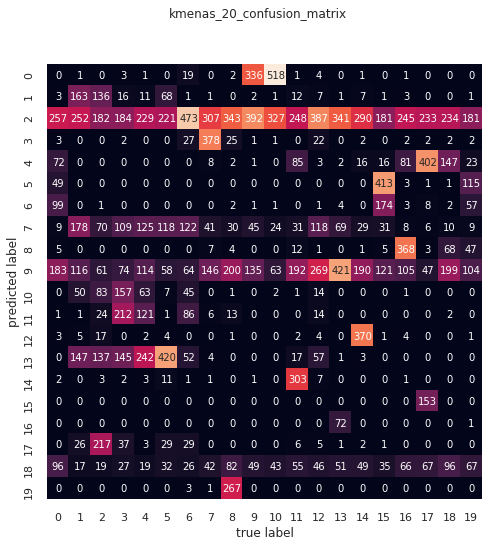

In [41]:
tfidf_adapter.plot_confusion_matrix(0, title='kmenas_20_confusion_matrix')

'read kmenas_16'

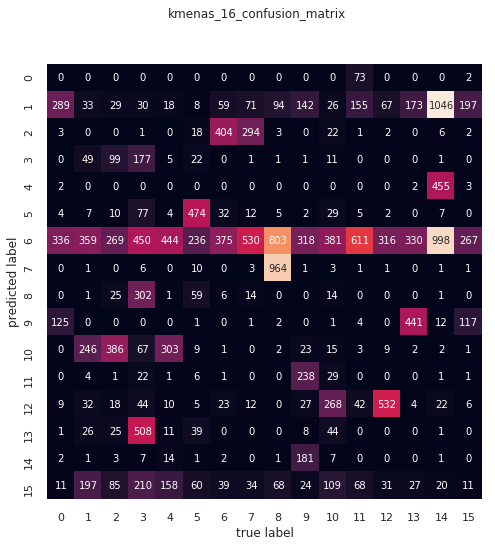

In [42]:
tfidf_adapter.plot_confusion_matrix(1, title='kmenas_16_confusion_matrix')

'read kmenas_7'

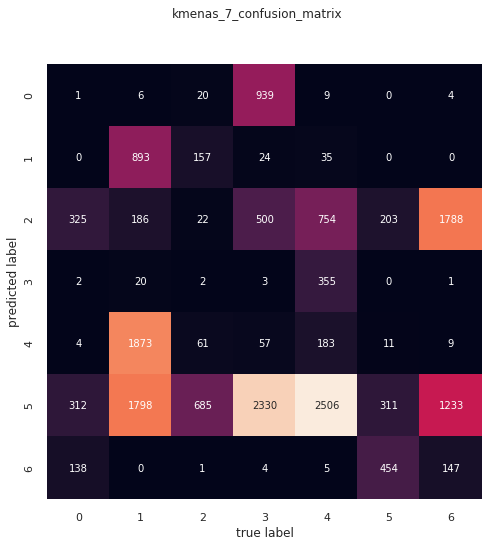

In [43]:
tfidf_adapter.plot_confusion_matrix(2, title='kmenas_7_confusion_matrix')

In [44]:
tfidf_adapter.calculate_metrics(0)

'read kmenas_20'

{'adjusted_mutual_info_score': 0.3014178484062217,
 'adjusted_rand_score': 0.06810421105991954,
 'completeness_score': 0.33643585672856485,
 'homogeneity_score': 0.27720978037874683,
 'v_measure_score': 0.30396471290792054}

In [45]:
tfidf_adapter.calculate_metrics(1)

'read kmenas_16'

{'adjusted_mutual_info_score': 0.3331788240663835,
 'adjusted_rand_score': 0.09043747354955896,
 'completeness_score': 0.3728382532918957,
 'homogeneity_score': 0.3039152684212182,
 'v_measure_score': 0.33486707993797177}

In [46]:
tfidf_adapter.calculate_metrics(2)

'read kmenas_7'

{'adjusted_mutual_info_score': 0.2604713111042972,
 'adjusted_rand_score': 0.09924834743846876,
 'completeness_score': 0.28675837137973553,
 'homogeneity_score': 0.23935836152918816,
 'v_measure_score': 0.2609231360072096}